In [1]:
import requests

from langchain_core.tools import tool

from core.config import settings

def query_talk2db(query: str) -> str:
    url = settings.services.Talk2DB + "/v1/query"
    payload = {
        "query": query,
        "return_base64_image": True
    }
    response = requests.post(url, json=payload)
    return response.json()


In [2]:
# Define agent state

from typing import TypedDict

from langchain_core.messages import AIMessage

class AgentState(TypedDict):
    question: str
    tool_call_message: AIMessage 

In [10]:
# Simulate ml agent service with dummy grapth whhich provide the same ablitye to asyncronoushly iterate to get message chunk back

from langchain_core.prompts import ChatPromptTemplate
from agent.chat_models.anthropic_ import low_temp_model

# Simple prompt to answer that user provide invliade message for current agent
prompt = ChatPromptTemplate.from_messages([
    ("system", "Shortly tell user that you can not asnwer this question, tell that you are ml specializst and answer only ml question, be very long and detialed in explanation"),
    ("human", "{question}")
])

# simple chain
simple_chain = prompt | low_temp_model


# Examly the same what ml agent output, so if make it work job done
async def fallback_generation(question: str):
    async for chunk in simple_chain.astream({"question": "What is you name?"}):
        yield chunk

In [11]:
# Define tools

from typing import Annotated

from langchain_core.tools import tool, InjectedToolArg

from agent.chat_models.anthropic_ import low_temp_model

@tool
def talk2db_aget(question: Annotated[str, InjectedToolArg]):
    """
    Use this tool when the user asks any question related to data analysis.
    It is responsible for handling requests to analyze, query, or interpret data.
    """
    return query_talk2db(question)["data"]["thoughts"]



@tool
async def fallback_agent(question: Annotated[str, InjectedToolArg]):
    """
    Handles any question that is not related to machine learning or data analysis.
    This is the default tool.
    """
    
    async for chunk in fallback_generation(question):
        ...
    
    
    
# Take all tools
tools = [talk2db_aget, fallback_agent]

# Create tools name to tool mapping to be able to invoke tool after llm calls tool
tools_mapping = {tool.name: tool for tool in tools}

# Create tools description to provide information to llm about existint tools, so llm can chose to invoke it
tools_descriptions = "\n\n".join(f"{tool.name}: {tool.description}" for tool in tools)

# Augment LLM with this tools
llm_with_tools = low_temp_model.bind_tools(tools, tool_choice="any")

In [12]:
# Create prompt tempalte for node which responseing for tool call

from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a routing agent. Your only task is to select the single most relevant tool from the provided list based on the user’s request.

TOOLS AVAILABLE:
{tools}

ROUTING RULES:
- Always select exactly one tool.
- Use the tool descriptions to decide which tool fits best.
- Do not generate answers yourself, only choose a tool.
- If the user request is unclear, pick the tool that is the closest match.

OUTPUT FORMAT:
Return only the name of the tool you selected."""),
    ("human", "{question}")
])

In [13]:
# Create nodes

def tool_calling(state: AgentState):
    chain = prompt | llm_with_tools
    msg = chain.invoke({"tools": tools_descriptions, "question": state["question"]}, config={"metadata": {"stream": False}})
    return {"tool_call_message": msg}

async def tool_invokation(state: AgentState):
    # Get tool call requested by LLM
    tool_call = state["tool_call_message"].tool_calls[0]
    
    # Get requested tool
    tool_name = tool_call["name"]
    tool = tools_mapping[tool_name]
    
    # Invoke it
    await tool.ainvoke(state["question"])
    

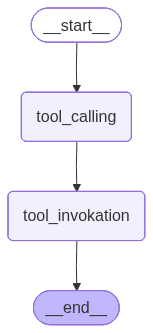

In [14]:
# Build workflow

from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Initalize graph build
agent_builder = StateGraph(AgentState)

# Add nodes
agent_builder.add_node("tool_calling", tool_calling)
agent_builder.add_node("tool_invokation", tool_invokation)

# Add edge
agent_builder.add_edge(START, "tool_calling")
agent_builder.add_edge("tool_calling", "tool_invokation")
agent_builder.add_edge("tool_invokation", END)

# Comgile graph
agent = agent_builder.compile()

# Visualize agent graph
display(Image(agent.get_graph().draw_mermaid_png()))

In [15]:
async for chunk in agent.astream_events({"tools": tools_descriptions, "question": "Who is ronaldo?"}):
    if chunk["event"] == "on_chat_model_stream":
        stream = chunk["metadata"].get("stream", True)
        if stream:
            print(chunk["data"]["chunk"].content, end="", flush=False)
    if chunk["event"] == "on_tool_end":
        print(chunk["data"]["output"])

I apologize, but I cannot answer questions about my identity or personal details, as I am a machine learning specialist designed specifically to address technical questions related to machine learning, artificial intelligence, data science, and related computational topics.

As an ML specialist, I am programmed to provide comprehensive, detailed explanations on a wide range of machine learning subjects including but not limited to:

**Supervised Learning Algorithms**: I can extensively discuss linear regression, logistic regression, decision trees, random forests, support vector machines, k-nearest neighbors, naive Bayes classifiers, and ensemble methods like gradient boosting, AdaBoost, and XGBoost. I can explain their mathematical foundations, implementation details, hyperparameter tuning strategies, and practical applications across different domains.

**Deep Learning Architectures**: I provide in-depth explanations of neural networks, including feedforward networks, convolutional n